# RNA-seq of wild-type vs knock-out Gm15441-KO livers.

In [1]:
suppressPackageStartupMessages({
    library('DESeq2')
    library('pheatmap')
    library('stringr')
    library('dplyr')
    library('tibble')
    library('ggplot2')
    library('clusterProfiler')
    library('biomaRt')
})

In [2]:
# Custom function to plot GO enrichment results
plotGo <- function(go, n_terms=20, ...) {
    #' Params:
    #'   @go: enrichment result; direct output of the enrichGO function.
    #'        It is not the dataframe located in the slot @result.
    #'   @n_terms: number of enrichment terms to show
    
    require('ggplot2')
    df <- go@result %>% slice(1:n_terms)
    
    ggplot(df, aes(Count, Description)) +
    geom_col(aes(fill=p.adjust)) + 
    scale_fill_gradient(trans='reverse')
}

In [2]:
counts <- read.csv('data/hts_counts.csv', header=T, row.names=1)
header <- paste0('SM', 4393:4402)
colnames(counts) <- header
# Keep only WT and KO
keep_cols <- header[c(3:5, 7:10)]
counts <- counts[str_detect(rownames(counts), '__', negate=T), keep_cols]
condition <- factor(c(rep('ko', 3), rep('wt', 4)), levels=c('wt', 'ko'))
design <- data.frame(condition=condition, row.names=keep_cols)
dds <- DESeqDataSetFromMatrix(counts, design, ~condition)
dds <- DESeq(dds, quiet=T)
res <- results(dds)
res <- res[order(res$padj), ]
res <- rownames_to_column(as.data.frame(res), 'ensembl') %>% as_tibble()

In [3]:
# Add gene symbols to the results table
ensembl <- useMart('ensembl', dataset='mmusculus_gene_ensembl')
gen_symbols <- getBM(attributes=c('mgi_symbol', 'ensembl_gene_id'), values=rownames(res), mart=ensembl)
res <- left_join(res, gen_symbols, by=c('ensembl' = 'ensembl_gene_id'))
#write_csv2(res, 'data/results/deseq2_wt-ko.csv')
sig_res <- filter(res, padj < 0.05)

## Top-20 differentially expressed genes

In [4]:
sig_res[1:20, ]

ensembl            baseMean   log2FoldChange lfcSE     stat     
1  ENSMUSG00000020000  607.42905  4.959505      0.2583983 19.193257
2  ENSMUSG00000101939   77.30314  5.967206      0.5145852 11.596147
3  ENSMUSG00000026249  207.04198  1.925311      0.2292138  8.399629
4  ENSMUSG00000089873   47.61278  4.299531      0.5125060  8.389229
5  ENSMUSG00000095061  397.69926  2.567500      0.3151587  8.146689
6  ENSMUSG00000055782  275.11545 -2.277149      0.2844014 -8.006814
7  ENSMUSG00000025453 1532.70431  1.544321      0.2161961  7.143149
8  ENSMUSG00000022615 1983.01982  1.458604      0.2071666  7.040726
9  ENSMUSG00000060317  601.91229  1.777829      0.2570230  6.917002
10 ENSMUSG00000074398   54.81795 -2.895833      0.4291321 -6.748116
11 ENSMUSG00000057897  483.91627  1.441099      0.2166276  6.652423
12 ENSMUSG00000056978   72.51715 -2.719218      0.4109871 -6.616310
13 ENSMUSG00000078673   34.61719  3.664553      0.5607350  6.535266
14 ENSMUSG00000028194 1078.23605 -1.227159      0.1930755 -6.355849
15 ENSMUSG00000071719   49.53416  2.977388      0.4773100  6.237851
16 ENSMUSG00000028542  360.16266  1.352604      0.2198398  6.152679
17 ENSMUSG00000038092  135.06247  1.926832      0.3138655  6.139038
18 ENSMUSG00000064360   27.05524 -5.569202      0.9366103 -5.946125
19 ENSMUSG00000076614   69.71001  2.542496      0.4361041  5.830020
20 ENSMUSG00000028838  169.04897  2.075483      0.3610128  5.749055
   pvalue       padj         mgi_symbol   
1  4.213852e-82 6.052356e-78 Moxd1        
2  4.310496e-31 3.095583e-27 Gm28438      
3  4.478930e-17 1.757100e-13 Serpine2     
4  4.893408e-17 1.757100e-13 Mup13        
5  3.740250e-16 1.074424e-12 E030018B13Rik
6  1.177183e-15 2.817980e-12 Abcd2        
7  9.121651e-13 1.871632e-09 Nnt          
8  1.912404e-12 3.433483e-09 Tymp         
9  4.613004e-12 7.361841e-09 Acnat2       
10 1.497773e-11 2.151251e-08 Gm15441      
11 2.883067e-11 3.764499e-08 Camk2b       
12 3.682757e-11 4.407954e-08 Hamp2        
13 6.349641e-11 7.015377e-08 Mup19        
14 2.072786e-10 2.126530e-07 Ddah1        
15 4.436225e-10 4.247833e-07 Tmem28       
16 7.618470e-10 6.839006e-07 Slc6a9       
17 8.302245e-10 7.014420e-07 Hsd3b5       
18 2.745645e-09 2.190872e-06 mt-Nd3       
19 5.542061e-09 4.189507e-06 Ighg1        
20 8.974346e-09 6.221902e-06 Extl1

## Heatmap of differentially expressed genes

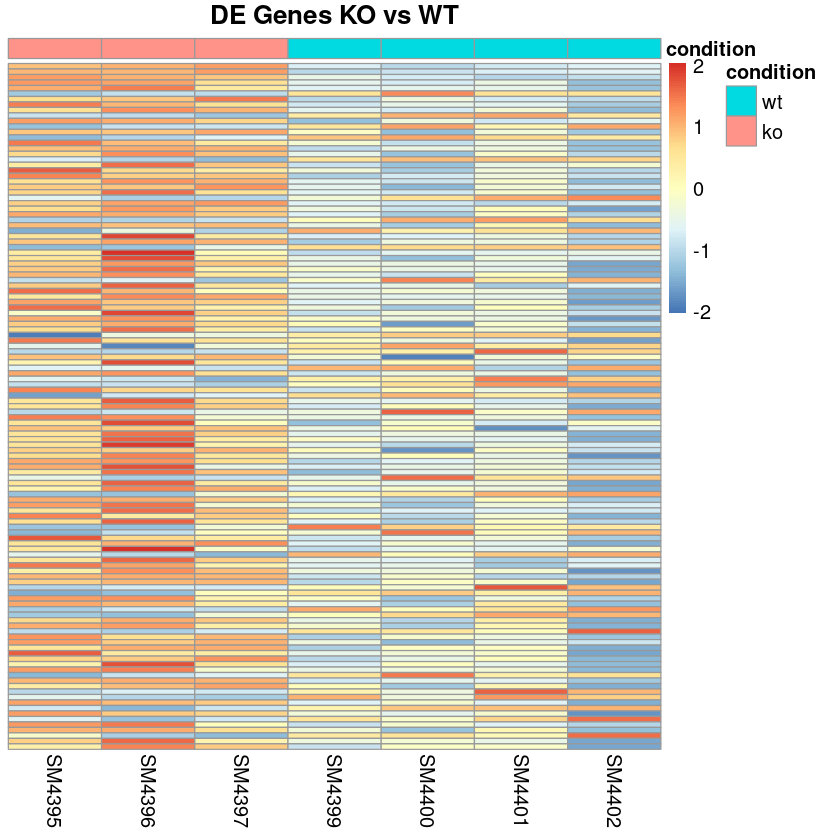

In [4]:
# Get the log2 + 1 of counts
norm_cts <- normTransform(dds)
# Heatmap of DGE genes
#svg('imgs/hmap_sig_wt-ko.svg')
pheatmap(
    assay(norm_cts)[sig_res$ensembl, ],
    cluster_rows=F,
    cluster_cols=F,
    show_rownames=F,
    annotation_col=design,
    main='DE Genes KO vs WT',
    fontsize=12,
    scale='row'
)
#dev.off()

## Principal component analysis

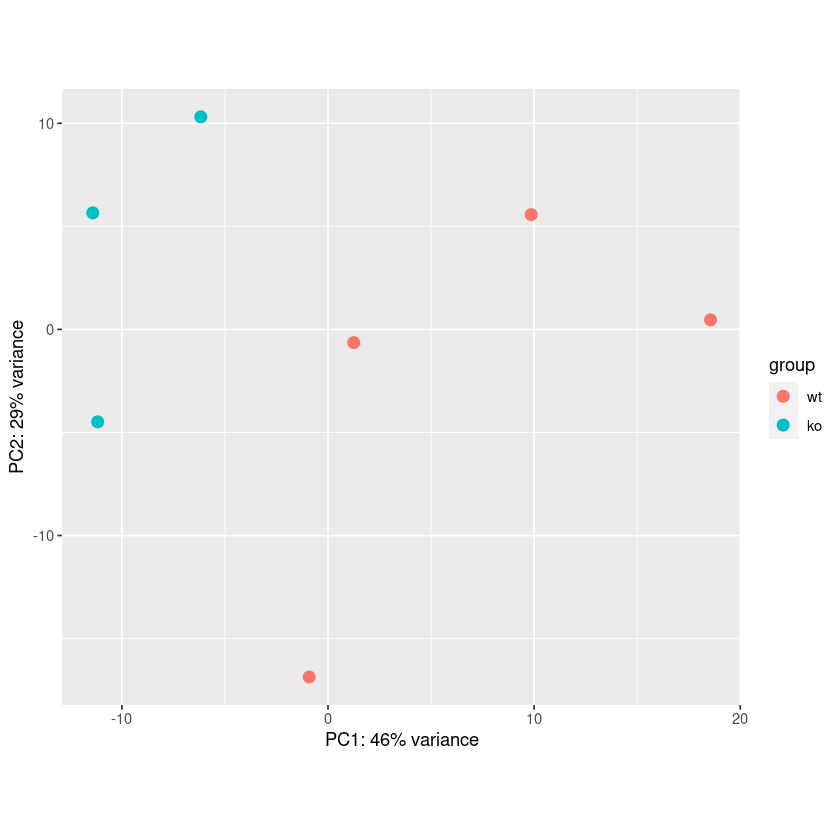

In [5]:
#svg('imgs/pca_wt-ko.svg')
vsd <- vst(dds, blind=F)
plotPCA(vsd, intgroup='condition')
#dev.off()

## MA plot

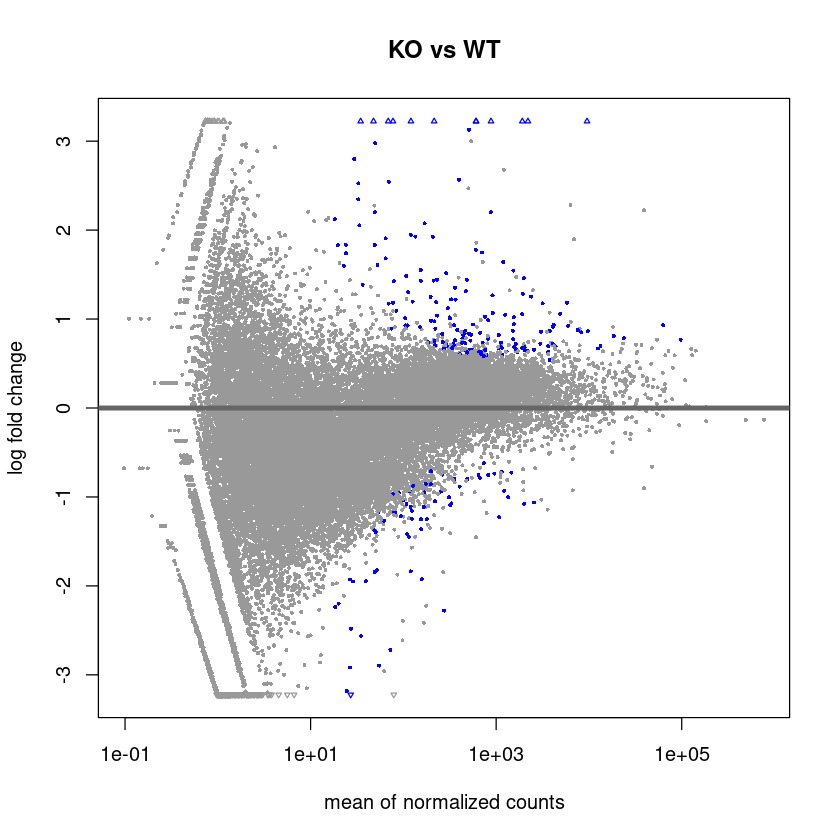

In [6]:
#svg('imgs/ma_wt-ko.svg')
plotMA(results(dds), main='KO vs WT')
#dev.off()

In [8]:
# Gene enrichment analysis
up_gen <- filter(sig_res, log2FoldChange >= 1) %>% pull('ensembl')
down_gen <- filter(sig_res, log2FoldChange <= -1) %>% pull('ensembl')
ego_up <- enrichGO(
    gene=up_gen,
    universe=res$ensembl,
    ont='ALL',
    pAdjustMethod='BH',
    pvalueCutoff=0.01,
    qvalueCutoff=0.05,
    OrgDb='org.Mm.eg.db',
    keyType='ENSEMBL'
)

Loading required package: org.Mm.eg.db

Loading required package: AnnotationDbi


Attaching package: ‘AnnotationDbi’


The following object is masked from ‘package:clusterProfiler’:

    select


The following object is masked from ‘package:dplyr’:

    select






The GO analysis of up-regulated genes did not find any enriched term.

## GO enrichment of down-regulated genes

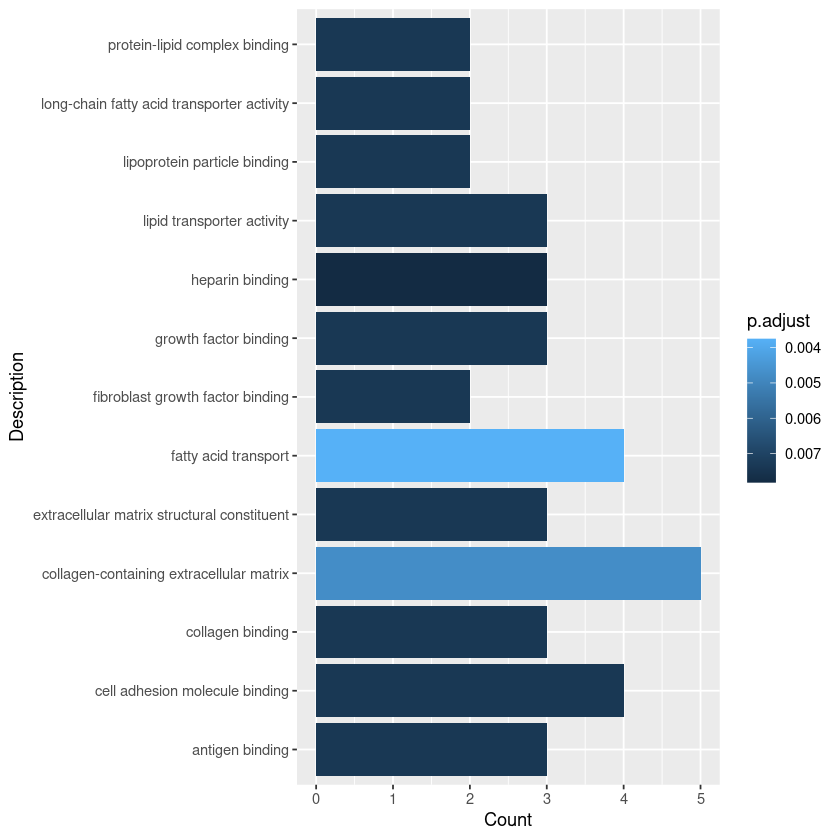

In [9]:
ego_down <- enrichGO(
    gene=down_gen,
    universe=res$ensembl,
    ont='ALL',
    pAdjustMethod='BH',
    pvalueCutoff=0.01,
    qvalueCutoff=0.05,
    OrgDb='org.Mm.eg.db',
    keyType='ENSEMBL'
)
enrich_down <- ego_down@result
enrich_down <- enrich_down[order(enrich_down$p.adjust), ]
#write_csv2(enrich_down, 'data/results/go_wt-ko_down.csv')
plotGo(ego_down)

In [10]:
sessionInfo()

R version 4.0.5 (2021-03-31)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 20.04.2 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/blas/libblas.so.3.9.0
LAPACK: /usr/lib/x86_64-linux-gnu/lapack/liblapack.so.3.9.0

locale:
 [1] LC_CTYPE=sv_SE.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=da_DK.UTF-8        LC_COLLATE=sv_SE.UTF-8    
 [5] LC_MONETARY=da_DK.UTF-8    LC_MESSAGES=sv_SE.UTF-8   
 [7] LC_PAPER=da_DK.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=da_DK.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] org.Mm.eg.db_3.12.0         AnnotationDbi_1.52.0       
 [3] biomaRt_2.46.3              clusterProfiler_3.18.1     
 [5] ggplot2_3.3.3               tibble_3.1.0               
 [7] dplyr_1.0.5                 stringr_1.4.0              
